# End-to-end test -- from a DSM to a DTM
with error/bias analysis

## Imports
### pytorch-unet

In [1]:
import os

if not os.path.exists("pytorch_unet.py"):
    if not os.path.exists("pytorch_unet"):
        !git clone https://github.com/akigoat/pytorch-unet.git

    # %cd pytorch-unet

fatal: destination path 'pytorch-unet' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm, trange
import math
# files
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import shutil
from pathlib import Path
# from scipy import interpolate
import matplotlib.pyplot as plt
# GIS
from osgeo import gdal
import rasterio
from affine import Affine
import richdem as rd
from rasterio.fill import fillnodata
# torch and dataset
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

# functions
import sys
sys.path.append('pytorch-unet')
import helper
import loss
import simulation

import dataFunctions
import netClasses

In [3]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [30]:
device = torch.device("mps")
path_folder = '/Volumes/HydesT7/Grad Project/Data/U_Net/64_64_1_8/'
path_model_folder = '/Volumes/HydesT7/Grad Project/Model/U_Net/1013/'
path_ANH4 = '/Volumes/HydesT7/Grad Project/Data/AHN4_all/'
path_pre = '/Volumes/HydesT7/Grad Project/Data/AHN4_preprocessed_1_8/'

means = np.load(path_folder+'para_means.npy')
stds = np.load(path_folder+'para_stds.npy')

# dsm, aspect, slope, roughness, tpi, tri

# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([means[0], means[2], means[3]], [
                         stds[0], stds[2], stds[3]])  # imagenet
])


In [31]:
list_patch = []
with open(path_ANH4+'picked.txt') as fp:
    # list_patch.append(patch)
    list_patch = [line.rstrip('\n') for line in fp]
print(list_patch[:5], len(list_patch))

['05FZ1', '05FZ2', '05GN2', '05GZ1', '05GZ2'] 505


In [32]:
from pathlib import Path
# Path("data/tmp").mkdir(parents=True, exist_ok=True)
tmp_path = 'data/tmp/'
xres = 30
yres = 30
resample_alg = 'average'
Path(tmp_path).mkdir(parents=True, exist_ok=True)
for filename in os.listdir(tmp_path):
    file_path = os.path.join(tmp_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [33]:
it = random.choice(list_patch)

In [34]:
dsm = path_ANH4+'R5_'+it+'.TIF'

In [35]:
data_ = gdal.Open(dsm, gdal.GA_ReadOnly)
# ndv = 3.4028230607371e+38
band_ = data_.GetRasterBand(1)
no_data = band_.GetNoDataValue()
# band_.SetNoDataValue(ndv)
ele_ = band_.ReadAsArray()
masked_ = np.ma.masked_where(ele_ > no_data/10, ele_)
if np.count_nonzero(masked_.mask == True) / (masked_.mask.shape[0]*masked_.mask.shape[1]) > 1/8:
    print('Warining: the dsm has no-data areas more than 1/8.')

In [36]:
dsm30 = tmp_path+'R30_'+it+'.TIF'
_ = gdal.Warp(dsm30, dsm, xRes=xres, yRes=yres, resampleAlg=resample_alg)
_ = None

with rasterio.open(dsm30) as src:
    profile = src.profile
    arr = src.read(1)
    arr_filled = fillnodata(arr, mask=src.read_masks(1), smoothing_iterations=0)

dsm30f = tmp_path+'R30_'+it+'_filled.TIF'  
with rasterio.open(dsm30f, 'w', **profile) as dest:
    dest.write_band(1, arr_filled)

slope_ = tmp_path+'R30_'+it+'_slope.TIF'
_ = gdal.DEMProcessing(slope_, dsm30f, 'slope', computeEdges=True)
_ = None
# if checkNodata(slope_):
#     list_hasnodata.append(slope_)

roughness_ = tmp_path+'R30_'+it+'_Roughness.TIF'
_ = gdal.DEMProcessing(roughness_, dsm30f, 'Roughness', computeEdges=True)
_ = None

In [37]:
dtm = path_ANH4+'M5_'+it+'.TIF'
dtm30 = tmp_path+'M30_'+it+'.TIF'
_ = gdal.Warp(dtm30, dtm, xRes=xres, yRes=yres, resampleAlg=resample_alg)
_ = None

In [38]:
cut_length = 64
cut_width = 64

# dsm_fill_slices = []
# slope_slices = []
# roughness_slices = []
# dsm30f_rd = rd.LoadGDAL(dsm30f)
# dsm30f_arr = np.asarray(dsm30f_rd)

dsm_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
    tmp_path, 'R30_'+it+'.TIF', masked=True), cut_width, cut_length)
dtm_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
    tmp_path, 'M30_'+it+'.TIF', masked=True), cut_width, cut_length)

dsm_fill_slices, dsm_dict = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
    tmp_path, 'R30_'+it+'_filled.TIF'), cut_length, cut_width, dt=True)
slope_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
    tmp_path, 'R30_'+it+'_slope.TIF'), cut_length, cut_width)
roughness_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
    tmp_path, 'R30_'+it+'_Roughness.TIF'), cut_length, cut_width)

Pics_roughness = dataFunctions.stackPics(dsm_fill_slices, slope_slices, roughness_slices)

In [39]:
ground_truth_slices = []
for nn in trange(len(dsm_slices)):
    ground_truth_slices.append(
        dataFunctions.generateGroundTruth(dsm_slices[nn], dtm_slices[nn]))

100%|██████████| 12/12 [00:00<00:00, 45.33it/s]


In [40]:
Masks = np.stack(ground_truth_slices)
Masks = Masks.astype(np.float32)
Masks.shape


(12, 2, 64, 64)

In [41]:
ground_truth_slices[0][0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [42]:
print(Pics_roughness.shape)
display(dsm_dict)


(12, 64, 64, 3)


{0: '0:64,0:64',
 1: '0:64,64:128',
 2: '0:64,103:167',
 3: '64:128,0:64',
 4: '64:128,64:128',
 5: '64:128,103:167',
 6: '128:192,0:64',
 7: '128:192,64:128',
 8: '128:192,103:167',
 9: '144:208,0:64',
 10: '144:208,64:128',
 11: '144:208,103:167'}

In [43]:
def mergeImg(im_list, im_dict, mask=False):
    height = int(im_dict[list(im_dict)[-1]].split(',')[0].split(':')[1])
    width = int(im_dict[list(im_dict)[-1]].split(',')[1].split(':')[1])
    im_merged = np.zeros((height, width), dtype=np.float32)
    if not mask:
        ndv = 3.4028230607370965e+38
        im_merged = im_merged-ndv
    else:
        im_merged = im_merged+0.5
    for k in im_dict:
        h0 = int(im_dict[k].split(',')[0].split(':')[0])
        h1 = int(im_dict[k].split(',')[0].split(':')[1])
        w0 = int(im_dict[k].split(',')[1].split(':')[0])
        w1 = int(im_dict[k].split(',')[1].split(':')[1])
        if not mask:
            im_merged[h0:h1, w0:w1] = np.where(
                im_list[k] > im_merged[h0:h1, w0:w1], im_list[k], im_merged[h0:h1, w0:w1])
        else:
            im_merged[h0:h1, w0:w1] = np.where(abs(
                im_list[k]-0.5) > abs(im_merged[h0:h1, w0:w1]-0.5), im_list[k], im_merged[h0:h1, w0:w1])
    return im_merged


In [44]:
gt = []
for mask in ground_truth_slices:
    gt.append(mask[1])

In [45]:
dsm_merged = mergeImg(dsm_fill_slices, dsm_dict)
rd_dsm_merged = rd.rdarray(dsm_merged, no_data=rd.LoadGDAL(dsm30f).no_data)

In [22]:
def colorMask(mask):
    colors = np.asarray([(83, 191, 157), (255, 197, 77)])

    colorimg = np.ones(
        (mask.shape[0], mask.shape[1], 3), dtype=np.float32) * 255
    height, width = mask.shape

    for y in range(height):
        for x in range(width):
            if mask[y, x] > 0.5:
                colorimg[y, x, :] = colors[1]
            else:
                colorimg[y, x, :] = colors[0]
            # selected_colors = colors[mask[y, x] > 0.5]

            # if len(selected_colors) > 0:
            #     colorimg[y, x, :] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

In [46]:
gt_w = mergeImg(gt, dsm_dict, mask=True)
gt_c = colorMask(mergeImg(gt, dsm_dict))
gt_c.shape

(208, 167, 3)

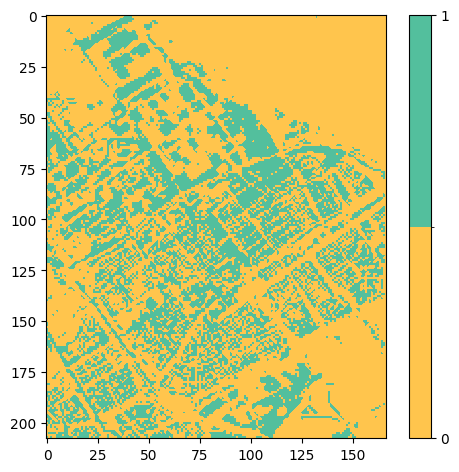

In [47]:
from matplotlib import colors
plt.figure(figsize=(6, 5.5))
color = [[255, 197, 77], [83, 191, 157]]
color = np.array(color)/255
cmap = colors.ListedColormap(color)
norm = colors.BoundaryNorm([0, 0.5, 1], 2, clip=True)
im = plt.imshow(gt_w, cmap=cmap, norm=norm)
# im = plt.imshow(gt_c)
plt.colorbar(im, ticks=np.linspace(0, 1, 2))
# plt.legend()
# fig.set_figure(im)
plt.show()

In [149]:
np.linspace(0, 1, 2)


array([0., 1.])

In [150]:
rd.LoadGDAL(dsm30f).no_data


3.4028230607370965e+38

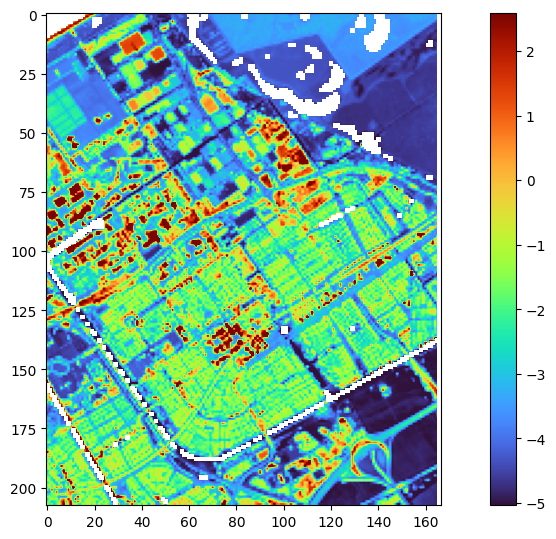

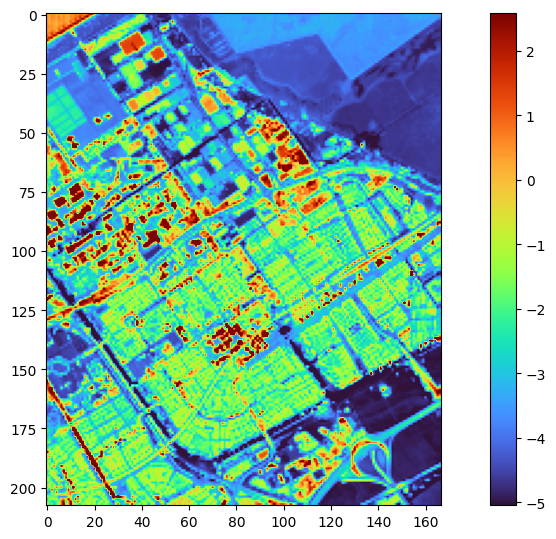

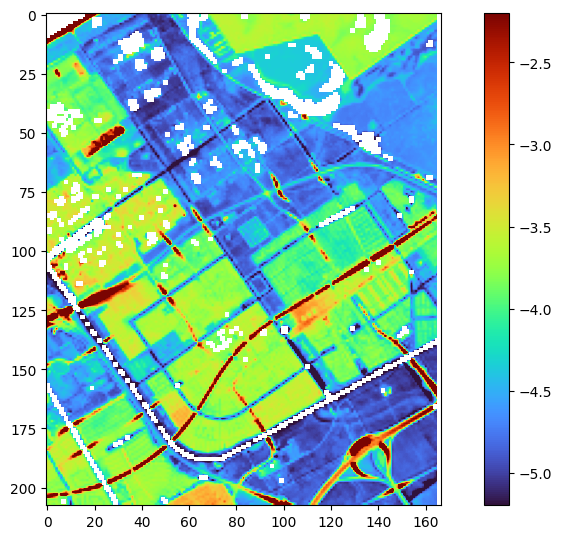

In [48]:
_ = rd.rdShow(rd.LoadGDAL(dsm30), axes=True, cmap='turbo', figsize=(6, 5.5))
_ = rd.rdShow(rd_dsm_merged, axes=True, cmap='turbo', figsize=(6, 5.5))
_ = rd.rdShow(rd.LoadGDAL(dtm30), axes=True, cmap='turbo', figsize=(6, 5.5))


In [49]:
test_dataset = netClasses.TestDataset2(Pics_roughness, Masks, transform=trans)


In [50]:
test_loader = DataLoader(test_dataset, batch_size=Pics_roughness.shape[0],
                         shuffle=False, num_workers=0)

# inputs, labels = next(iter(test_loader))

# # test_dataset.__len__
# inputs = inputs.to(device)
# labels = labels.to(device)
# print('inputs.shape', inputs.shape)
# print('labels.shape', labels.shape)

model = netClasses.ResNetUNet(2)
model = model.to(device)

model.load_state_dict(torch.load(path_model_folder+'roughness_20_1e-4.pt'))
model.eval()

# pred = model(inputs)
# # The loss functions include the sigmoid function.
# pred = torch.sigmoid(pred)
# pred = pred.data.cpu().numpy()
# print('pred.shape', pred.shape)

inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred.shape', pred.shape)

threshold, upper, lower = 0.5, 1, 0
pred = np.where(pred > threshold, upper, lower)

# Change channel-order and make 3 channels for matplot
# input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
input_images_rgb_ = [x.astype(np.uint8) for x in Pics_roughness]


# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]


/Users/hyde-mbp/opt/anaconda3/envs/torG/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hyde-mbp/opt/anaconda3/envs/torG/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


inputs.shape torch.Size([12, 3, 64, 64])
labels.shape torch.Size([12, 2, 64, 64])
pred.shape (12, 2, 64, 64)


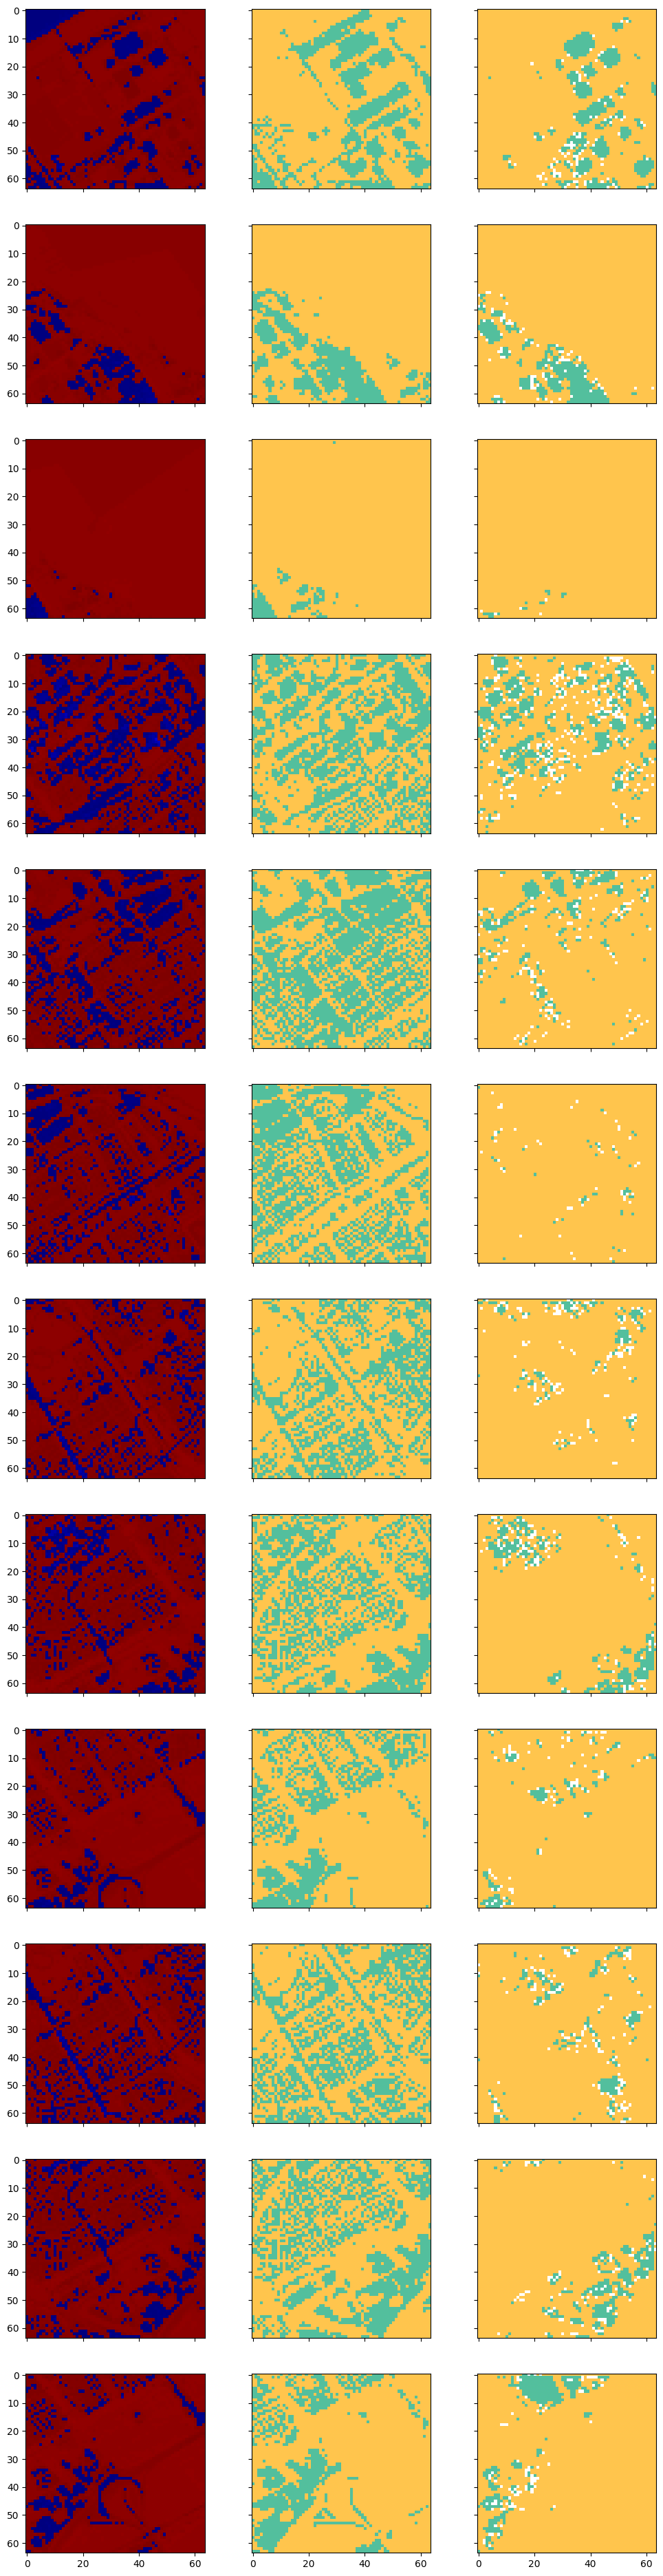

In [51]:
helper.plot_side_by_side([input_images_rgb_, target_masks_rgb, pred_rgb])


In [37]:
a = None
a = 'a'

In [38]:
if a:
    print('a')

a


In [26]:
threshold, upper, lower = 0.5, 1.0, 0.0
pred_ = np.where(pred>threshold, upper, lower)

In [52]:
pred_l = list(pred)

In [53]:
pred_l1 = []
for p in pred_l:
    pred_l1.append(p[1])

In [54]:
pred_w = mergeImg(pred_l1, dsm_dict, mask=True)
pred_w.shape

(208, 167)

In [36]:
208*167

34736

In [55]:
pred_w


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [56]:
gt_w

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [57]:
ac_count = 0
for i in range(pred_w.shape[0]):
    for j in range(pred_w.shape[1]):
        if abs(pred_w[i][j]-gt_w[i][j])<0.1:
            ac_count += 1
print(ac_count/(pred_w.shape[0]*pred_w.shape[1]))

0.7572259327498848


In [58]:
error_count = 0
error_wrong_judge = 0
error_missed = 0
error_ele = 0
bias_ele = []

dsm_ = dataFunctions.readTIFF(tmp_path, 'R30_'+it+'.TIF', masked=True)
dtm_ = dataFunctions.readTIFF(tmp_path, 'M30_'+it+'.TIF', masked=True)


for i in range(pred_w.shape[0]):
    for j in range(pred_w.shape[1]):
        if abs(pred_w[i][j]-gt_w[i][j])>0.1:
            error_count+=1
            if dsm_.mask[i][j]==True:
                error_wrong_judge += 1
            elif dtm_.mask[i][j]==False:
                error_missed += 1
            else:
                error_ele += 1
                bias_ele.append(dsm_.data[i][j]-dtm_.data[i][j])

In [59]:
print(error_count, error_wrong_judge, error_missed, error_ele)
display(bias_ele)

8433 6 8321 106


[-3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+38,
 -3.4028235e+3

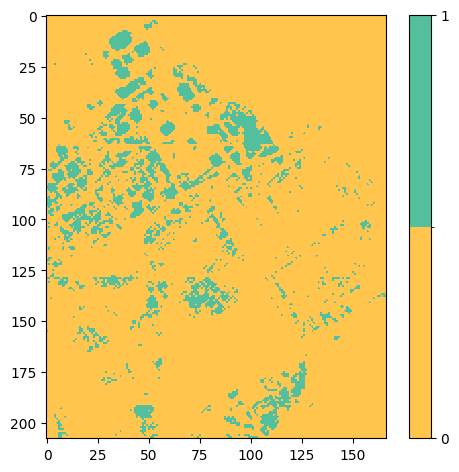

In [60]:
from matplotlib import colors
plt.figure(figsize=(6, 5.5))
color = [[255, 197, 77], [83, 191, 157]]
color = np.array(color)/255
cmap = colors.ListedColormap(color)
norm = colors.BoundaryNorm([0, 0.5, 1], 2, clip=True)
im = plt.imshow(pred_w, cmap=cmap, norm=norm)
# im = plt.imshow(gt_c)
plt.colorbar(im, ticks=np.linspace(0, 1, 2))
# plt.legend()
# fig.set_figure(im)
plt.show()


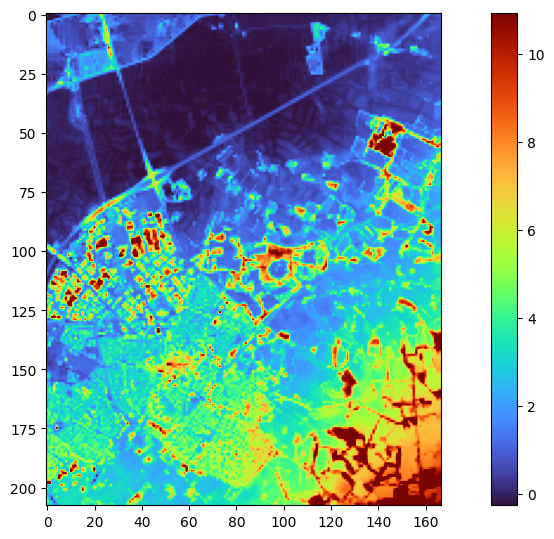

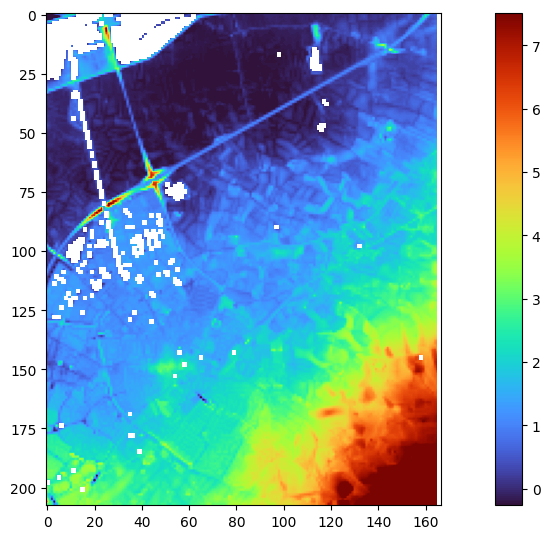

In [23]:
_ = rd.rdShow(rd.LoadGDAL(dsm30f), axes=True, cmap='turbo', figsize=(6, 5.5))
dtm_path = os.path.join(path_pre, 'M30_'+it+'.TIF')
_ = rd.rdShow(rd.LoadGDAL(dtm_path), axes=True, cmap='turbo', figsize=(6, 5.5))

In [ ]:
# list_hasnodata = []

pbar_ = tqdm(total=len(item_check))

for it in item_check:
# it = item_check[0]
    dsm5 = path_in+'R5_'+it+'.TIF'
    dtm5 = path_in+'M5_'+it+'.TIF'
    # resample:
    dsm30 = path_out+'R30_'+it+'.TIF'
    _ = gdal.Warp(dsm30, dsm5, xRes=xres, yRes=yres, resampleAlg=resample_alg)
    _ = None

    dtm30 = path_out+'M30_'+it+'.TIF'
    _ = gdal.Warp(dtm30, dtm5, xRes=xres, yRes=yres, resampleAlg=resample_alg)
    _ = None

    # fill nodata (for dsm30)
    with rasterio.open(dsm30) as src:
        profile = src.profile
        arr = src.read(1)
        arr_filled = fillnodata(arr, mask=src.read_masks(1), smoothing_iterations=0)

    dsm30f = path_out+'R30_'+it+'_filled.TIF'  
    with rasterio.open(dsm30f, 'w', **profile) as dest:
        dest.write_band(1, arr_filled)

    # compute attributes
    # "slope", "aspect", "TRI", "TPI", "Roughness"
    slope_ = path_out+'R30_'+it+'_slope.TIF'
    _ = gdal.DEMProcessing(slope_, dsm30f, 'slope', computeEdges=True)
    _ = None
    if checkNodata(slope_):
        list_hasnodata.append(slope_)

    aspect_ = path_out+'R30_'+it+'_aspect.TIF'
    _ = gdal.DEMProcessing(aspect_, dsm30f, 'aspect', computeEdges=True)
    _ = None
    if checkNodata(aspect_):
        list_hasnodata.append(aspect_)

    tri_ = path_out+'R30_'+it+'_TRI.TIF'
    _ = gdal.DEMProcessing(tri_, dsm30f, 'TRI', computeEdges=True)
    _ = None
    if checkNodata(tri_):
        list_hasnodata.append(tri_)

    tpi_ = path_out+'R30_'+it+'_TPI.TIF'
    _ = gdal.DEMProcessing(tpi_, dsm30f, 'TPI', computeEdges=True)
    _ = None
    if checkNodata(tpi_):
        list_hasnodata.append(tpi_)

    roughness_ = path_out+'R30_'+it+'_Roughness.TIF'
    _ = gdal.DEMProcessing(roughness_, dsm30f, 'Roughness', computeEdges=True)
    _ = None
    if checkNodata(roughness_):
        list_hasnodata.append(roughness_)

    pbar_.update(1)
pbar_.close()

    